In [1]:
#load data, condensed as we did this previously
def load_clinical_eeg_data(datapath, sub):
    import pandas as pd
    alldata = pd.read_csv(os.path.join(datapath, sub + '.csv')) #removed 'train' bc of how I saved
    alldata.rename(columns={'Unnamed: 0': 'Index'})
    eegevents = alldata[['labels', 'chunks']]
    alldata.drop(['Unnamed: 0', 'labels', 'chunks'], axis=1, inplace=True)
    names = alldata.keys()
    return alldata.iloc[:].as_matrix(), eegevents, names
import os
import numpy as np
os.chdir("C:\\Users\\adam1brownell\\Desktop\Winter2017\\188B Files\Project")
path = os.getcwd()

#Get subject names from appropriate dir, -4 for .csv suffux
subjects = [f[:-4] for f in os.listdir(path)]

data, label_chunk, nodes = load_clinical_eeg_data(path,subjects[3])

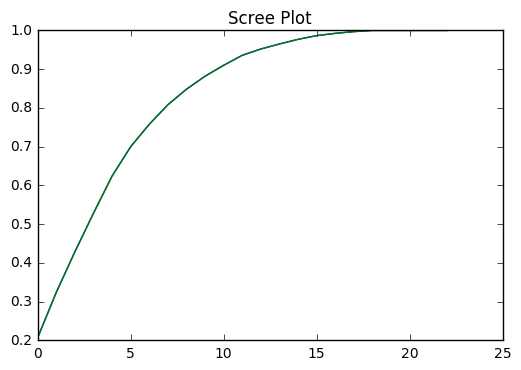

In [4]:
from sklearn.decomposition import PCA
import sklearn.preprocessing as prepro
import matplotlib.pyplot as plt
x_scaled = prepro.scale(data)
pca = PCA()
X_pca = pca.fit_transform(x_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Scree Plot')
plt.show()

In [14]:
#Based on Scree Plot we only need between 5 and 10 features, so reduce dataset
pca = PCA(n_components = 7)
x_pca = pca.fit_transform(x_scaled)

In [15]:
#Jeff Code for Filtering

def apply_filters(x, order=4, fs=512.0, filt=None, btype='low', axis=0):
    from scipy.signal import butter, filtfilt
    nyq = .5 * fs
    
    if filt is None:
        return x
    if isinstance(filt, list):
        f = [i/nyq for i in filt]
        btype='band'
    else:
        f = filt/nyq
        
    b, a = butter(order, f, btype=btype, analog=False)
    x = filtfilt(b, a, x, axis=axis)
    return x

def plot_filter(order=4, fs=512.0, filt=None, btype='low'):
    from scipy.signal import decimate, butter, freqs
    nyq = .5 * fs
    if filt is None:
        return None
    if isinstance(filt, list) and len(filt) > 1:
        f = [i/nyq for i in filt]
        btype='band'
    else:
        f = filt/nyq
    b, a = butter(order, f, btype=btype, analog=True)
    w, h = freqs(b, a)
    plt.plot(w, 20 * np.log10(abs(h)))
    plt.xscale('log')
    plt.title('Butterworth filter frequency response')
    plt.xlabel('Frequency [radians / second]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()

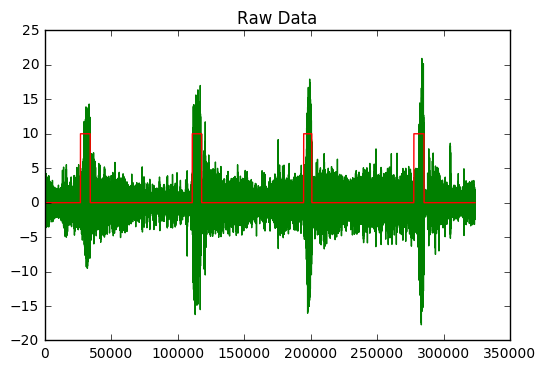

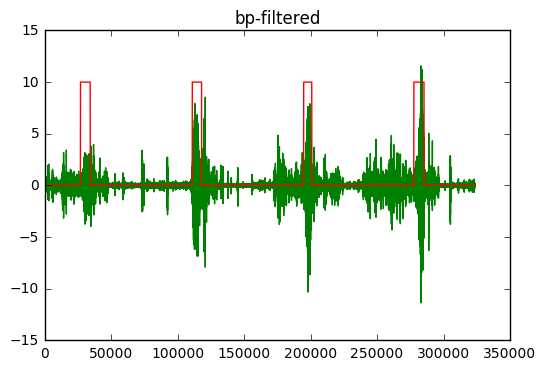

In [59]:
big_labels = np.array(label_chunk)[:,0] *10
plt.plot(x_pca[:,3], color = 'green')
plt.plot(big_labels, color = 'red')
plt.title('Raw Data')
plt.show()
x_filt = apply_filters(x_pca[:,3], order=4, fs=64, filt=[12, 30], btype='band')
plt.plot(x_filt, color = 'green')
plt.plot(big_labels, color = 'red')
plt.title('bp-filtered')
plt.show()

In [92]:
#Band Pass is effective at identifying seizures
x_bp = apply_filters(x_pca, order=4, fs=64, filt=[12, 30], btype='band')

In [133]:
# Our dataset is very one-sided, and wee need to sample evenly to avoid our models only predicting "no seizure"
def re_label3(data,labels):
    non_szr = []
    pre_szr = []
    szr = []

    marker = 0
    f_label = labels
    f_data = data
    for i in range(0, len(f_label)):
        if f_label[i] == 0:
            marker = 0
            if i < len(f_label) - 640 and f_label[i + 640] != 1:
                non_szr.append(f_data[i])

        elif f_label[i] == 1 and marker == 0:
            marker = 1

            for n in range(640, 1, -1):
                pre_szr.append(f_data[i - n])

        elif f_label[i] == 1 and marker == 1:
            szr.append(f_data[i])

    pre_szr = np.asarray(pre_szr)
    szr = np.asarray(szr)
    non_szr = np.asarray(non_szr)
    
    return non_szr, szr, pre_szr

def sample_sizer(labelList, n, *args):
    samples = []
    for arg in args:
        for i in range(n):
            samples.append(arg[i,:])
            
    labelr = []
    for labels in labelList:
        for i in range(n):
            labelr.append(labels)
    return np.array(samples), np.array(labelr)

In [134]:
#Build equally sized data sets
labels = np.array(label_chunk)[:,0]
nonData, seizData, preData = re_label3(x_bp, labels)

#Shuffle each list
np.random.shuffle(nonData)
np.random.shuffle(seizData)
np.random.shuffle(preData)

#generate a new dataset
size = 64 * 30 # ~30 sec of each data type
new_data, new_labels = sample_sizer([0,1,2], size, nonData,preData,seizData)

In [138]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.cross_validation as ms

#Identifying Naive Bayes
new_data, new_labels = sample_sizer([0,1], size, nonData,seizData)
x_train, x_test, y_train, y_test = ms.train_test_split(new_data, new_labels)

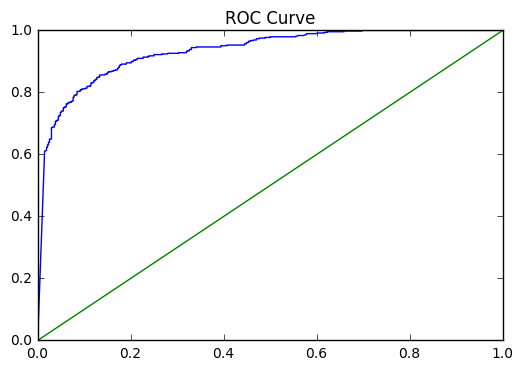

AUC:  0.933230150736
Accuracy:  0.845833333333


In [139]:
#Identifying Naive Bayes
from sklearn.naive_bayes import GaussianNB

new_data, new_labels = sample_sizer([0,1], size, nonData,seizData)
x_train, x_test, y_train, y_test = ms.train_test_split(new_data, new_labels)

nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
nb_predict = nb_model.predict_proba(x_test)

#ROC Curve
import sklearn.metrics as met
fpr1, tpr1, treshholds = met.roc_curve(y_test,nb_predict[:,1])
x1 = [0,1]
y1 = [0,1]
plt.plot(fpr1,tpr1)
plt.plot(x1,y1)
plt.title('ROC Curve')
plt.show()
print "AUC: ", met.auc(fpr1,tpr1)
print "Accuracy: ", nb_model.score(x_test,y_test)

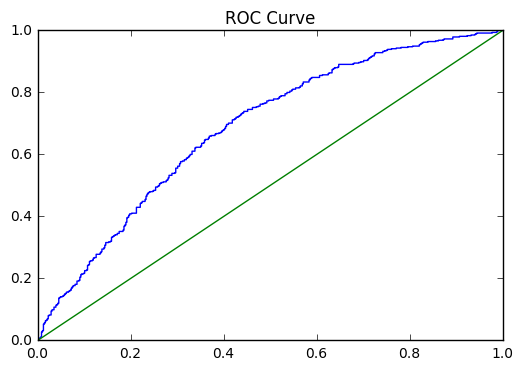

AUC:  0.685022246337
Accuracy:  0.589583333333


In [137]:
#Predictive Naive Bayes Model:
np.random.shuffle(nonData)
np.random.shuffle(preData)
size = 64 * 30 # ~30 sec of each data type
new_data, new_labels = sample_sizer([0,1], size, nonData,preData)
x_train, x_test, y_train, y_test = ms.train_test_split(new_data, new_labels)
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)
nb_predict = nb_model.predict_proba(x_test)

#ROC Curve
import sklearn.metrics as met
fpr1, tpr1, treshholds = met.roc_curve(y_test,nb_predict[:,1])
x1 = [0,1]
y1 = [0,1]
plt.plot(fpr1,tpr1)
plt.plot(x1,y1)
plt.title('ROC Curve')
plt.show()
print "AUC: ", met.auc(fpr1,tpr1)
print "Accuracy: ", nb_model.score(x_test,y_test)